In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [4]:
def Correlation(map1, map2):
    return hp.anafast(map1,map2)/np.sqrt(hp.anafast(map1)*hp.anafast(map2))

In [5]:
model = tf.keras.models.load_model('./SavedModels/R2.81/',custom_objects={'r_square':r_square})

In [6]:
#Data
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

overdensDataBase = np.zeros((numSets,12*nside**2))
kSZDataBase = np.zeros((numSets,12*nside**2))
velDataBase = np.zeros((numSets,12*nside**2))

for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
    overdensData[i] = 100*overdensData[i]/np.linalg.norm(overdensData[i])
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    kSZData[i] = 100*kSZData[i]/np.linalg.norm(kSZData[i])
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
    velData[i] = 100*velData[i]/np.linalg.norm(velData[i])

In [7]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-numSets//20])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-numSets//20])

In [8]:
numComp = 100

In [9]:
recontructedMaps = model(x_train[0:numComp]).numpy()

In [10]:
reconstructedMapsComp = hp.reorder(np.reshape(recontructedMaps,(len(recontructedMaps),12*nside**2)),n2r=True)

In [11]:
y_trainComp = hp.reorder(y_train,n2r=True)
overdensDataComp = hp.reorder(overdensData,n2r=True)
kSZDataComp = hp.reorder(kSZData,n2r=True)

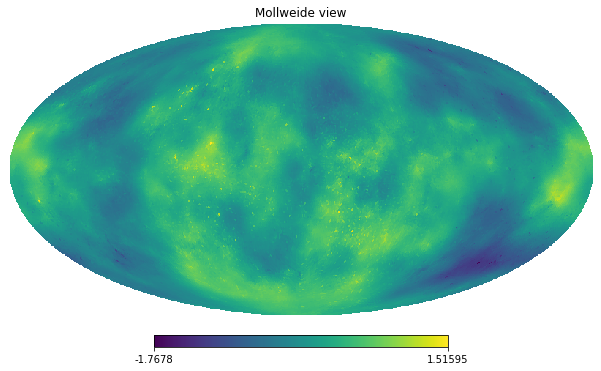

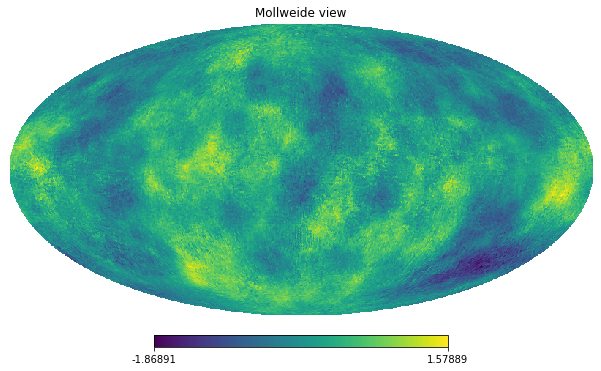

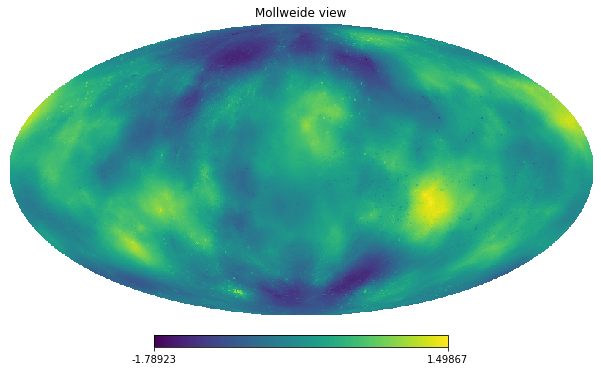

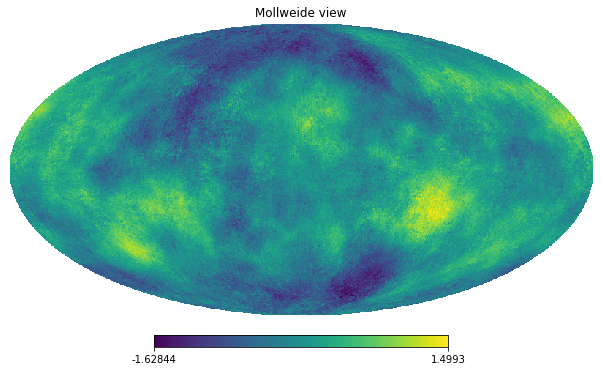

In [12]:
for i in range(0,2):
    hp.mollview(reconstructedMapsComp[i])
    hp.mollview(y_trainComp[i])

In [13]:
sumCorr = Correlation(reconstructedMapsComp[0],y_trainComp[0])

for i in range(1,numComp):
    sumCorr = sumCorr + Correlation(reconstructedMapsComp[i],y_trainComp[i])
    
sumCorr = sumCorr/numComp

(0.0, 1.0)

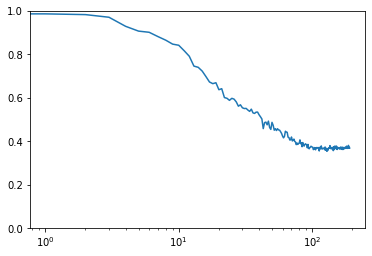

In [14]:
plt.semilogx(sumCorr)
plt.ylim([0,1])

# Quadratic Estimator

In [15]:
import camb
#import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [16]:
#Make Fake CMB
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

#rho map is just the overdensity
def quadEst(ksz_map, rho_map):
    
    ksz_PS = hp.anafast(ksz_map)

    CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);
    
    Obs_T_map = ksz_map + CMB_map

    ClTT = hp.anafast(Obs_T_map)
    ClTT_filtered = np.concatenate(([1.0], savgol_filter(ClTT[1:], 51, 3)))
    
    dTlm = hp.map2alm(Obs_T_map)
    dlm = hp.map2alm(rho_map)

    dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
    dT_resc = hp.alm2map(dTlm_resc, nside)
    dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
    d_resc = hp.alm2map(dlm, nside)

    unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc)
    unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
    unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)

    return unnorm_veff_reconst

<ipython-input-16-1a7c52bad834>:11: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [17]:
quadMaps = np.zeros((numComp,12*nside**2))

for i in range(numComp):
    quadMaps[i,:] = quadEst(kSZDataComp[i,:],overdensDataComp[i,:])

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [18]:
sumCorrQuad = Correlation(quadMaps[0],y_trainComp[0])

for i in range(1,numComp):
    sumCorrQuad = sumCorrQuad + Correlation(quadMaps[i],y_trainComp[i])
    
sumCorrQuad = sumCorrQuad/numComp

(-0.2, 1.0)

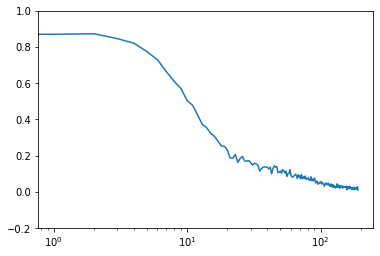

In [19]:
plt.semilogx(sumCorrQuad)
plt.ylim([-0.2,1])

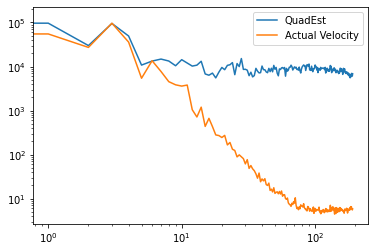

In [20]:
plt.figure()
plt.loglog(hp.anafast(quadMaps[0]))
plt.loglog(hp.anafast(y_trainComp[0]*10**3))
plt.legend(["QuadEst","Actual Velocity"]);

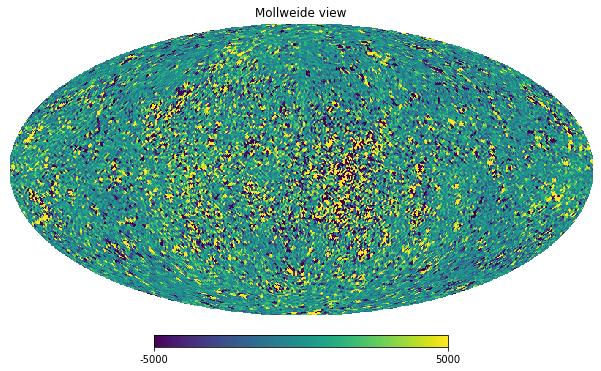

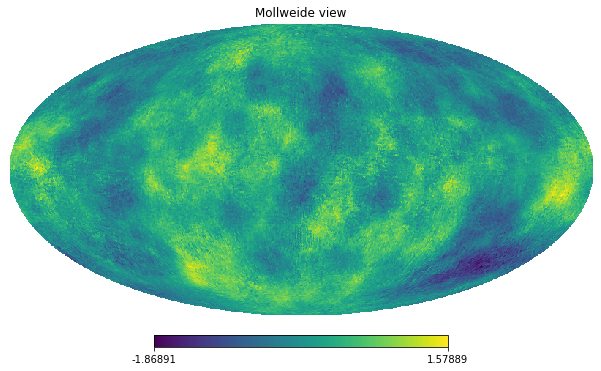

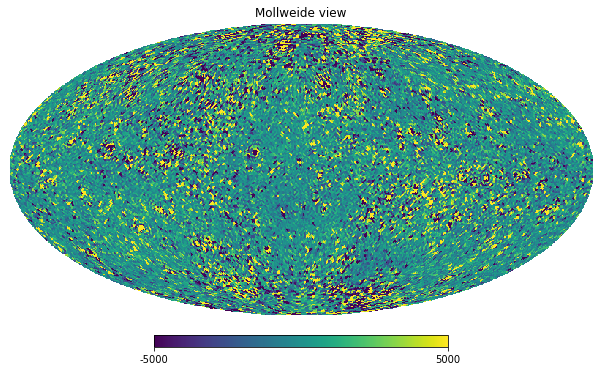

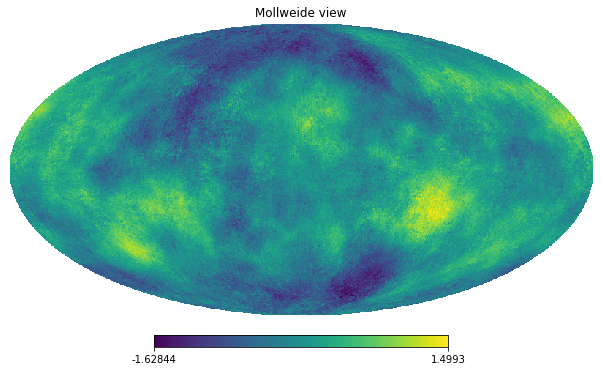

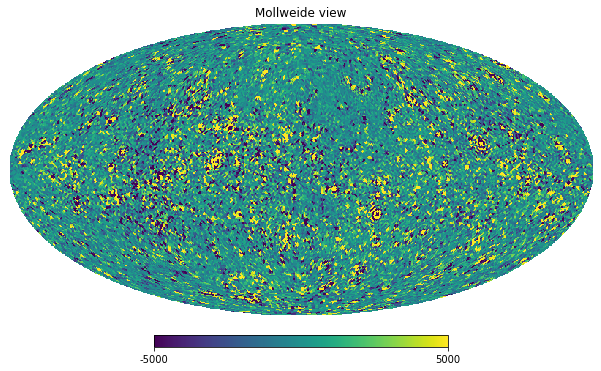

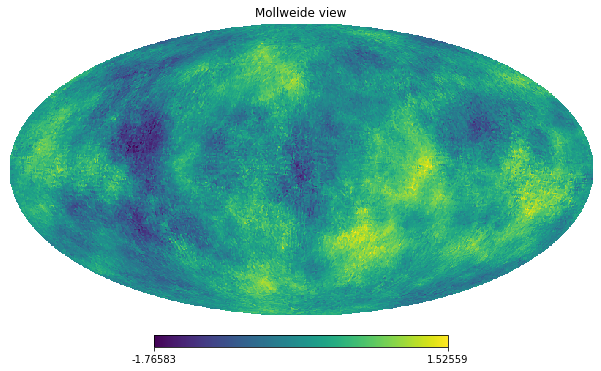

In [21]:
for i in range(0,3):
    hp.mollview(quadMaps[i],max=5000,min=-5000)
    hp.mollview(y_trainComp[i])

# Just Divide

In [22]:
divMaps = np.zeros((numComp,12*nside**2))

for i in range(numComp):
    divMaps[i,:] = kSZDataComp[i,:]/overdensDataComp[i,:]

In [23]:
sumCorrDiv = Correlation(divMaps[0],y_trainComp[0])

for i in range(1,numComp):
    sumCorrDiv = sumCorrDiv + Correlation(divMaps[i],y_trainComp[i])
    
sumCorrDiv = sumCorrDiv/numComp

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 257.831008 arcmin (0.075000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 607.145625 arcmin
  warnings.warn(


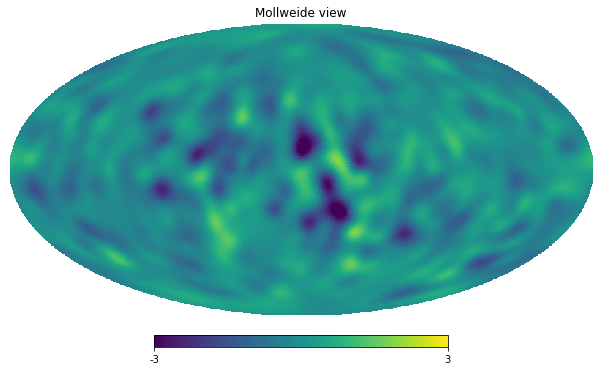

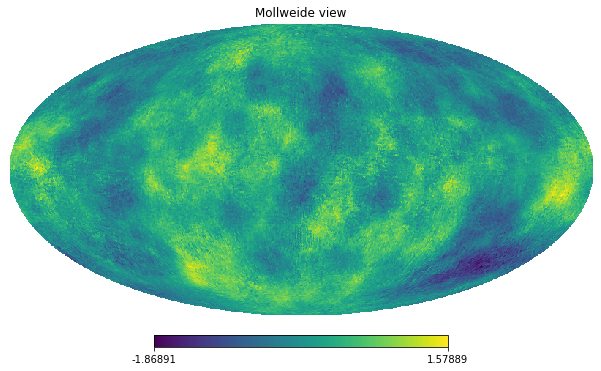

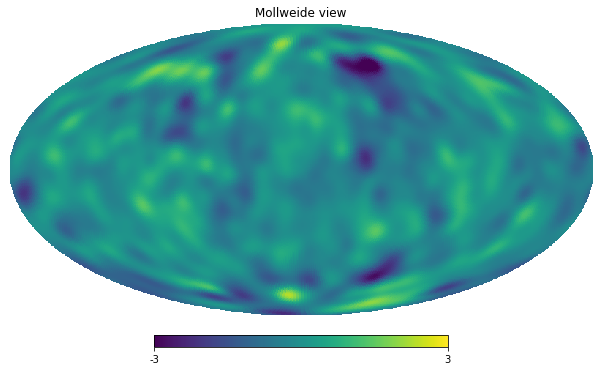

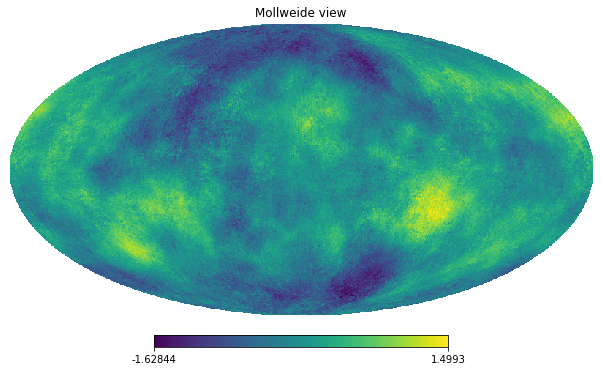

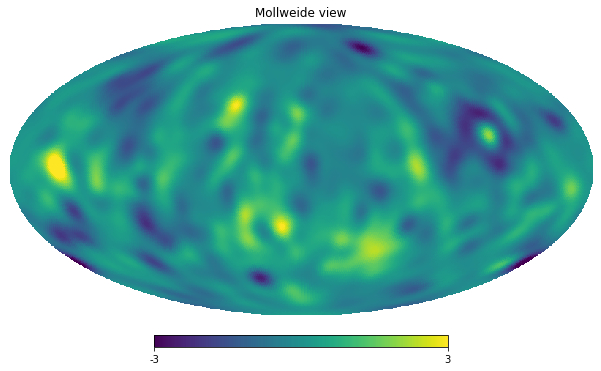

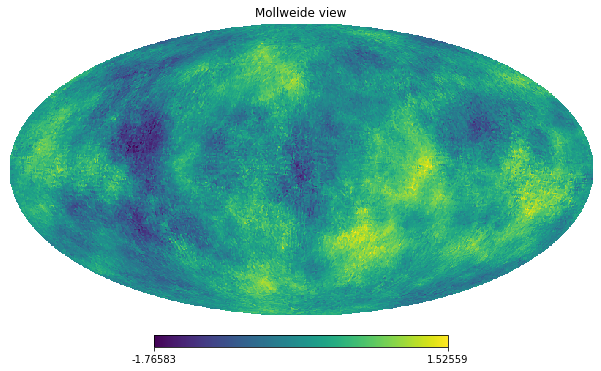

In [49]:
for i in range(0,3):
    hp.mollview(hp.smoothing(divMaps[i],sigma=.075),max=3,min=-3)
    hp.mollview(y_trainComp[i])

(-0.2, 1.0)

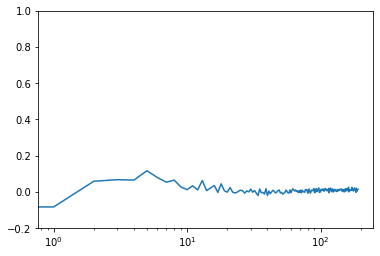

In [24]:
plt.semilogx(sumCorrDiv)
plt.ylim([-0.2,1])

# Comparison

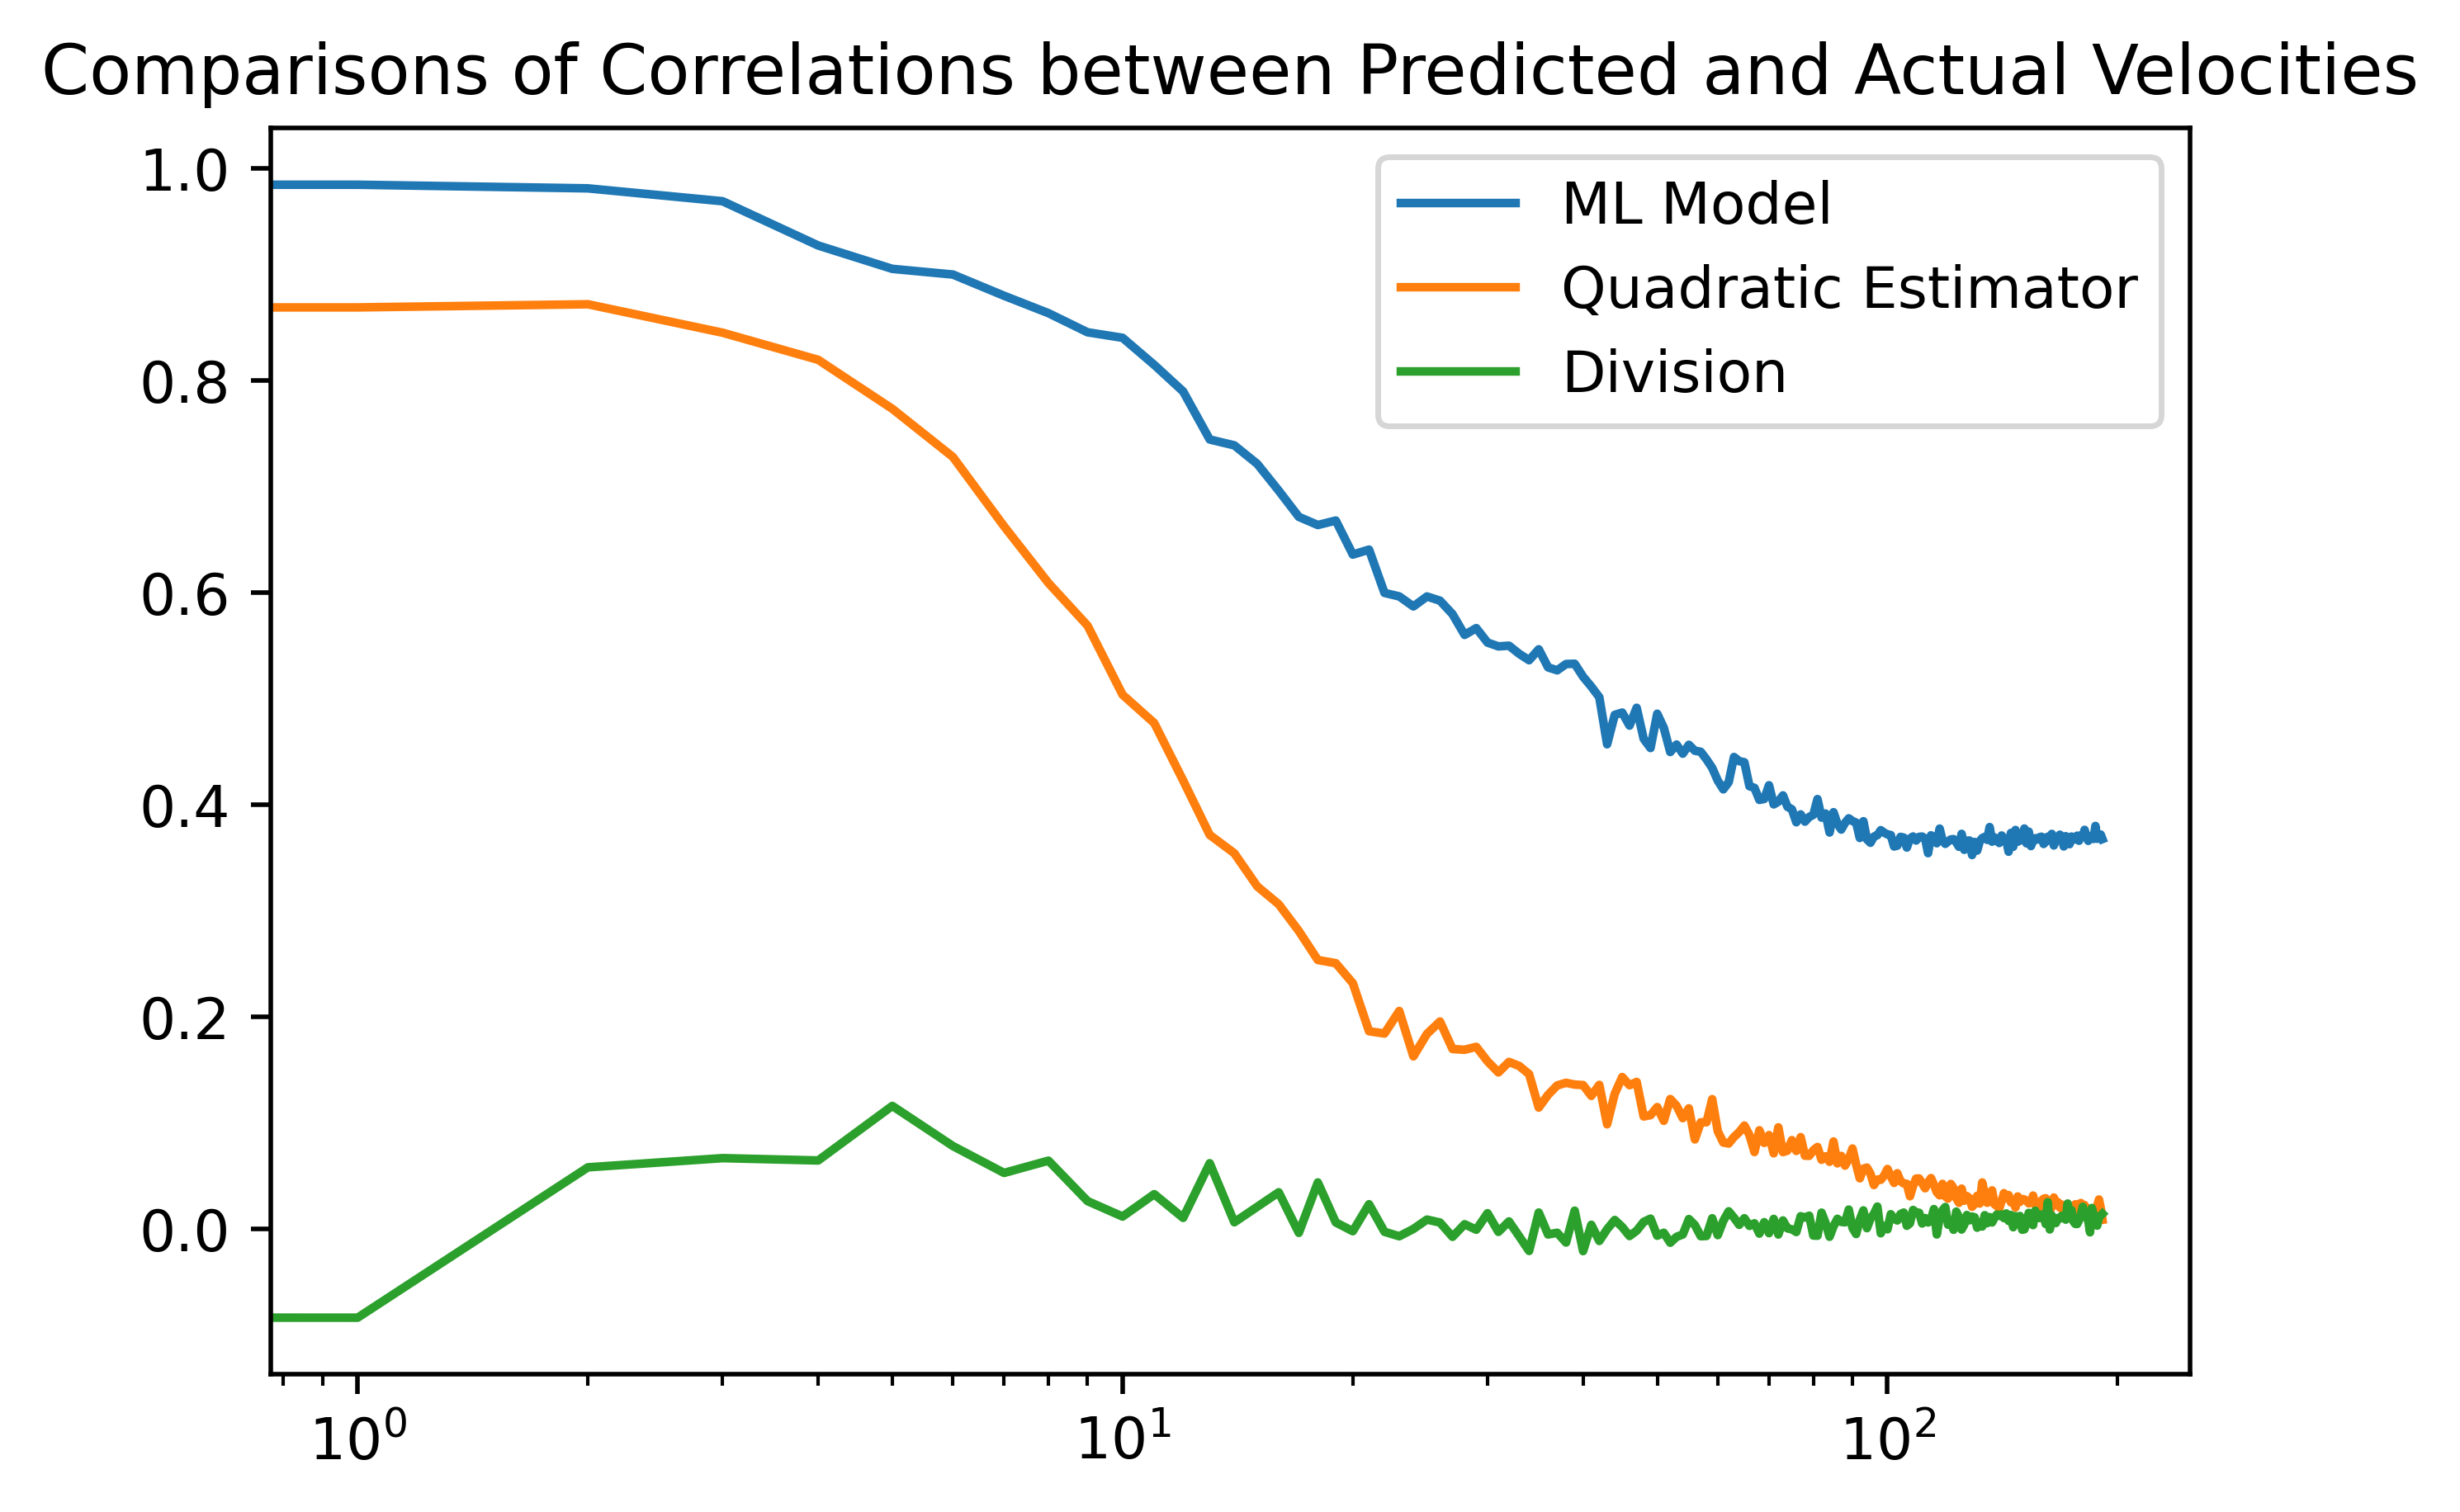

In [25]:
plt.figure(dpi=500)
plt.semilogx(sumCorr);
plt.semilogx(sumCorrQuad);
plt.semilogx(sumCorrDiv);
plt.legend(["ML Model","Quadratic Estimator","Division"]);
plt.title("Comparisons of Correlations between Predicted and Actual Velocities");